# Foray into Unsupervised Learning - Trying to Predict Attention Switches with Clustering
Jupyter Notebook for processing the EEG time-series values of subjects across subjects and readings, encoding them using an autoencoder, performing analysis on their dimensionally reduced time series values, and from there using statistical methods to calculate the probability distribution across samples, hierarchical clustering and a dendrogram to determine the optimal number of clusters for agglomerative clustering, and finally training a clustering model using that value. 
- Note, in the following code the pertinent libraries are imported and the functions for extracting data are defined and called on. 
- The first 600 epochs are used from the 1200 epoch dataset because the dataset includes the readings of two subjects.
- Data used can be accessed at the following link: https://drive.google.com/file/d/1QsJaBU-MFJUCN9dUnPFxeLoATlHP8nMk/view?usp=sharing

In [40]:
import tensorflow as tf
from datetime import datetime
import numpy as np
import pandas as pd
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, TimeDistributed, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import scipy.io
import scipy.cluster.hierarchy as sch
import matplotlib.pylab as plt
from sklearn.cluster import AgglomerativeClustering
import os
import seaborn as sns
import random
tf.autograph.set_verbosity(0)

def get_path(directory, filename):
    return f"../../data/{directory}/{filename}"

def extract_mat(file_name, start_step, end_step, label_electrodes=[]):
    # extract the data from the file in form [sample, electrodes, timestep]
    path = get_path("Switches", file_name)
    data = scipy.io.loadmat(path)
    # treating the data, flattening it 
    epochs = np.array([[electrode[0].squeeze() for electrode in epoch.squeeze()] for epoch in data['EEG_ChanData']['Epoch'].squeeze()])
    return np.delete(epochs[:,:,start_step:end_step], label_electrodes, 1)

def standardize(data):
    for i, s in enumerate(data):
        data[i] = (data[i]-s.mean(axis=0))/s.std(axis=0)
    return data

def extract_switches(filename):
    path = get_path("Switches", filename)
    data = pd.read_csv(path)
    return np.array(data.iloc[:,3] == "R")


# reading and standardizing the
drop = [0,2,5,6,7,8,9,10,11,12,13,14,18,19,20,21,22,23,24,25,26,27,29,31]
data = standardize(extract_mat("EEG_ChanData.mat", 0, 180, drop)).swapaxes(1,2)[:600]
labels = extract_switches("data_Variables.csv")[:600]
low = len(data)//7

(600, 180, 8)


## Training the Autoencoder
- Training an encoder to reduce the dimensionality of the multidimensional time series electrode readings for each epoch to a single array, effectively turning a dataset of [epoch, timestep, electrode] to [epoch, timestep]. This is important for the unsupervised learning approach that I am trying to take in identifying switches.
- TimeDistributed layers are used here to maintain consistency in applying the layer weights to every time step. This is important for an encoder.

In [43]:
class myCallback(tf.keras.callbacks.Callback): 
    def __init__(self, threshold) -> None:
        self.threshold = threshold
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > self.threshold):   
            print(f"\nReached {self.threshold} accuracy on epoch number {epoch}, stopping training")   
            self.model.stop_training = True

def create_callback(early=False, patience=10, min_delta=0.00001):
    callback = [ModelCheckpoint(f'../../models/model_{datetime.now()}.h5', verbose=0,
        save_best_only=False, save_weights_only=False, save_freq='epoch')]
    callback.append(myCallback(0.999))
    if early: 
        callback.append(EarlyStopping(monitor='loss', min_delta=min_delta, patience=patience, verbose=1))
    return callback

def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

def get_autoencoder(data):
    set_seed(33)
    length = data.shape[1]
    encoder = Sequential()
    encoder.add(Input(shape=(data.shape[1], data.shape[2])))
    # [encoder.add(TimeDistributed(Dense(length//i, activation='tanh'))) for i in [3, 7, 10, 7, 3]]
    # # [encoder.add(TimeDistributed(Dense(length//i, activation='relu'))) for i in [1, 3, 7, 10, 7, 3, 1]]
    encoder.add(TimeDistributed(Dense(250, activation='tanh')))
    encoder.add(TimeDistributed(Dense(100, activation='tanh')))
    encoder.add(TimeDistributed(Dense(25, activation='tanh')))
    encoder.add(TimeDistributed(Dense(100, activation='tanh')))
    encoder.add(TimeDistributed(Dense(250, activation='tanh')))
    encoder.add(TimeDistributed(Dense(data.shape[2])))
    encoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return encoder

model = get_autoencoder(data)
model.fit(data[:low],data[:low], epochs=200, verbose=1, 
    validation_data=(data[low:low+10],data[low:low+10]), batch_size=2,
    callbacks=create_callback(early=True, patience=15))
model.summary()

Epoch 1/200
 1/43 [..............................] - ETA: 12s - loss: 0.9901 - accuracy: 0.0889

2021-12-23 00:27:33.836360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 13ms/step - loss: 0.1310 - accuracy: 0.6445 - val_loss: 0.0181 - val_accuracy: 0.8844
Epoch 2/200
15/43 [=========>....................] - ETA: 0s - loss: 0.0129 - accuracy: 0.8587

2021-12-23 00:27:34.473950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 0s 9ms/step - loss: 0.0099 - accuracy: 0.8549 - val_loss: 0.0065 - val_accuracy: 0.9244
Epoch 3/200
43/43 [==============================] - 0s 9ms/step - loss: 0.0046 - accuracy: 0.8920 - val_loss: 0.0033 - val_accuracy: 0.9550
Epoch 4/200
43/43 [==============================] - 0s 9ms/step - loss: 0.0022 - accuracy: 0.9405 - val_loss: 0.0021 - val_accuracy: 0.9739
Epoch 5/200
43/43 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.9518 - val_loss: 0.0019 - val_accuracy: 0.9617
Epoch 6/200
43/43 [==============================] - 0s 9ms/step - loss: 0.0012 - accuracy: 0.9577 - val_loss: 0.0014 - val_accuracy: 0.9683
Epoch 7/200
43/43 [==============================] - 0s 9ms/step - loss: 0.0010 - accuracy: 0.9637 - val_loss: 9.6226e-04 - val_accuracy: 0.9756
Epoch 8/200
43/43 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.9402 - val_loss: 0.0015 - val_accuracy: 0.9650
Epoch 9/200
43/43 [==

## Graphing Auto-encoder Results
- Displaying the auto-encoder result accuracy as MSE graphs comparing encdoded signal similarity to the original signal. 
- The differences in trends between mean squared errors in regards to time can be used to train a model, both a supervised model with the labels of Left and Right as well as something unsupervised, which is what is done in this notebook. 

2021-12-23 00:27:56.355582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


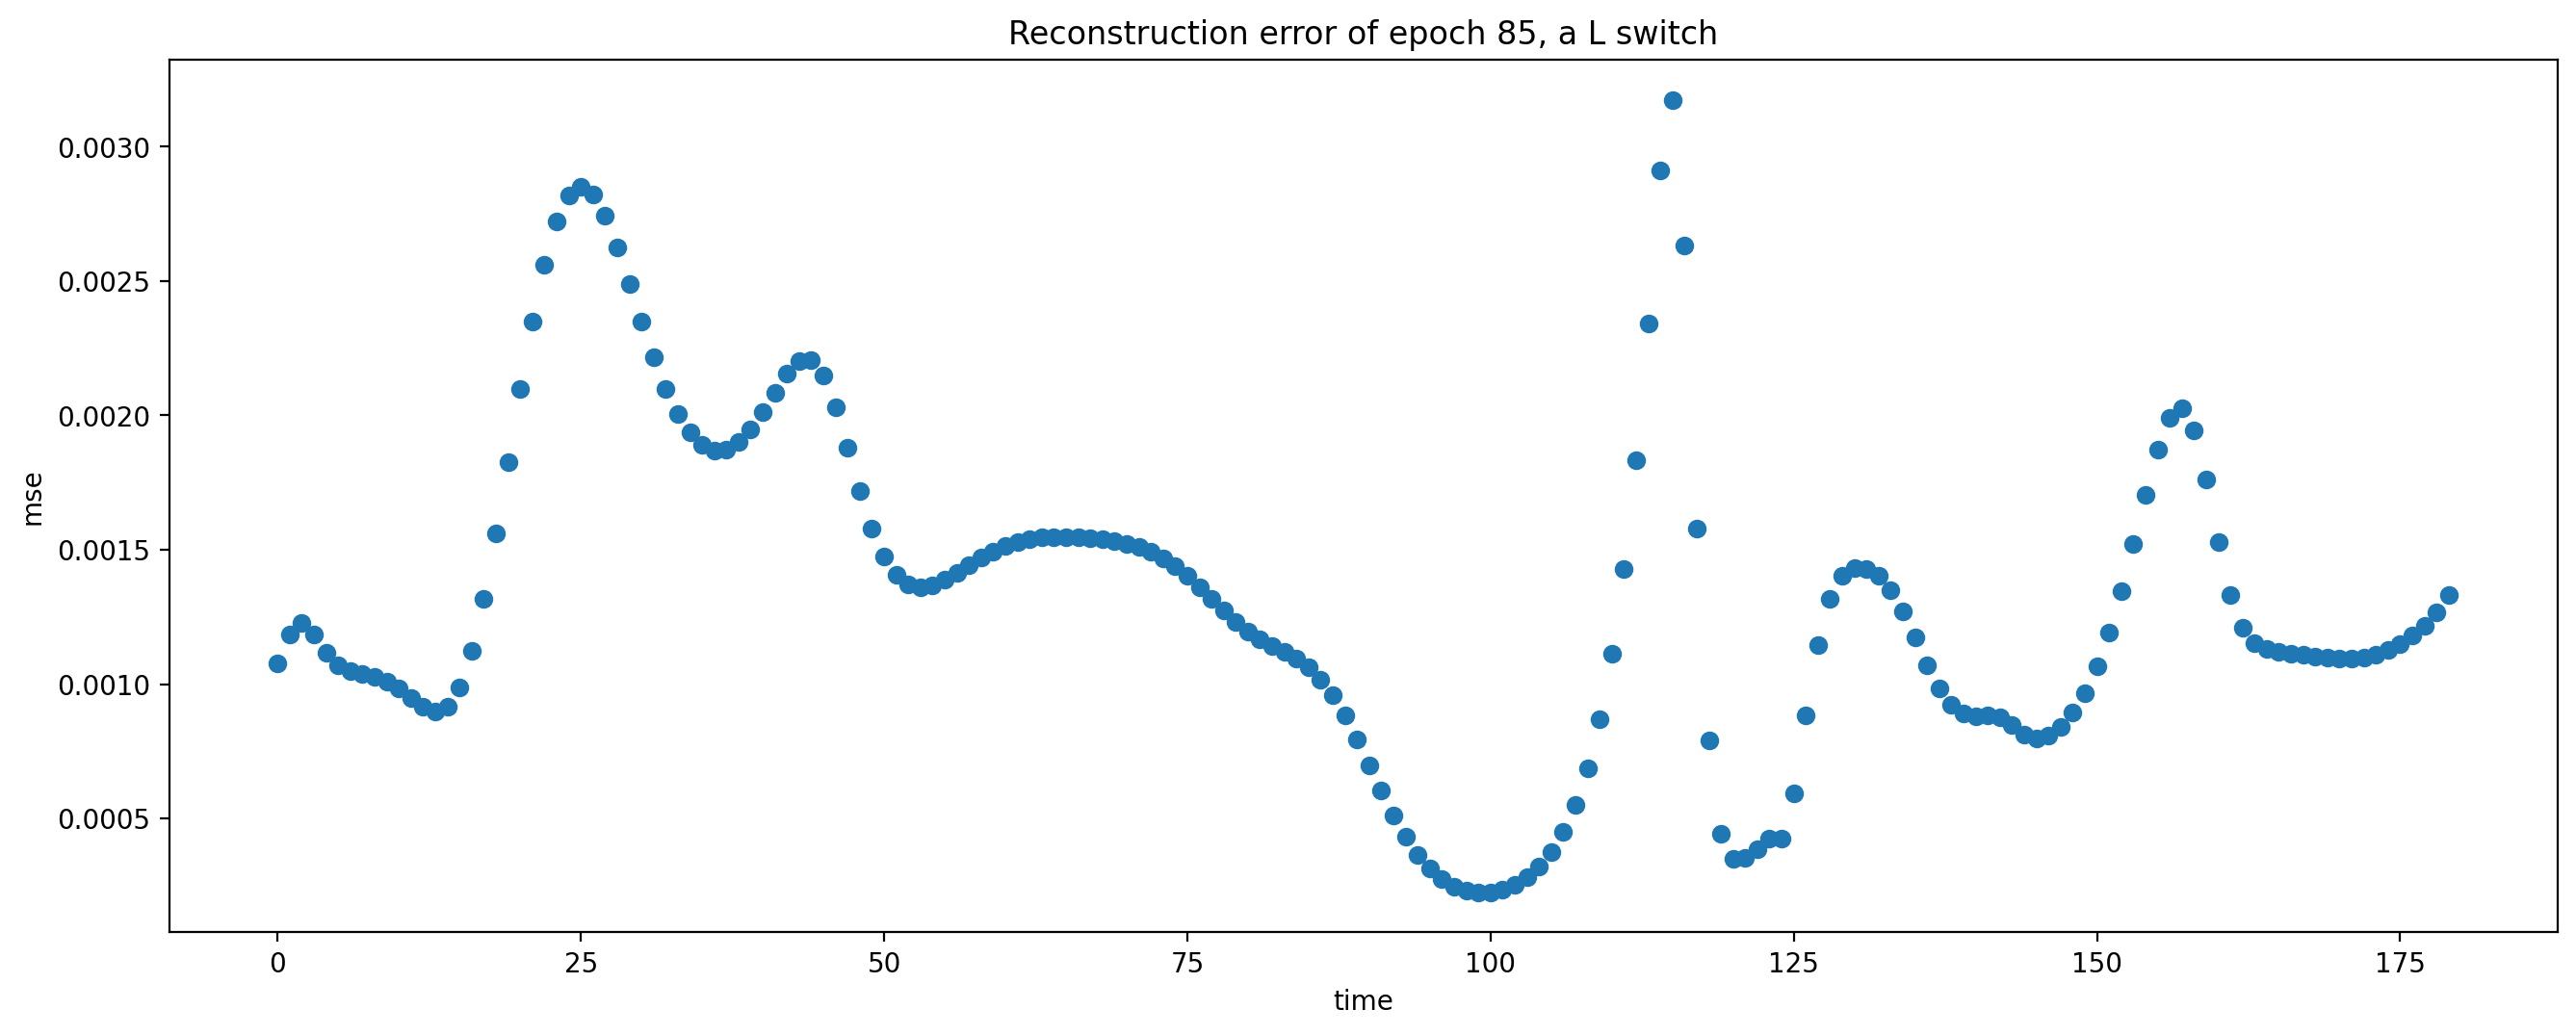

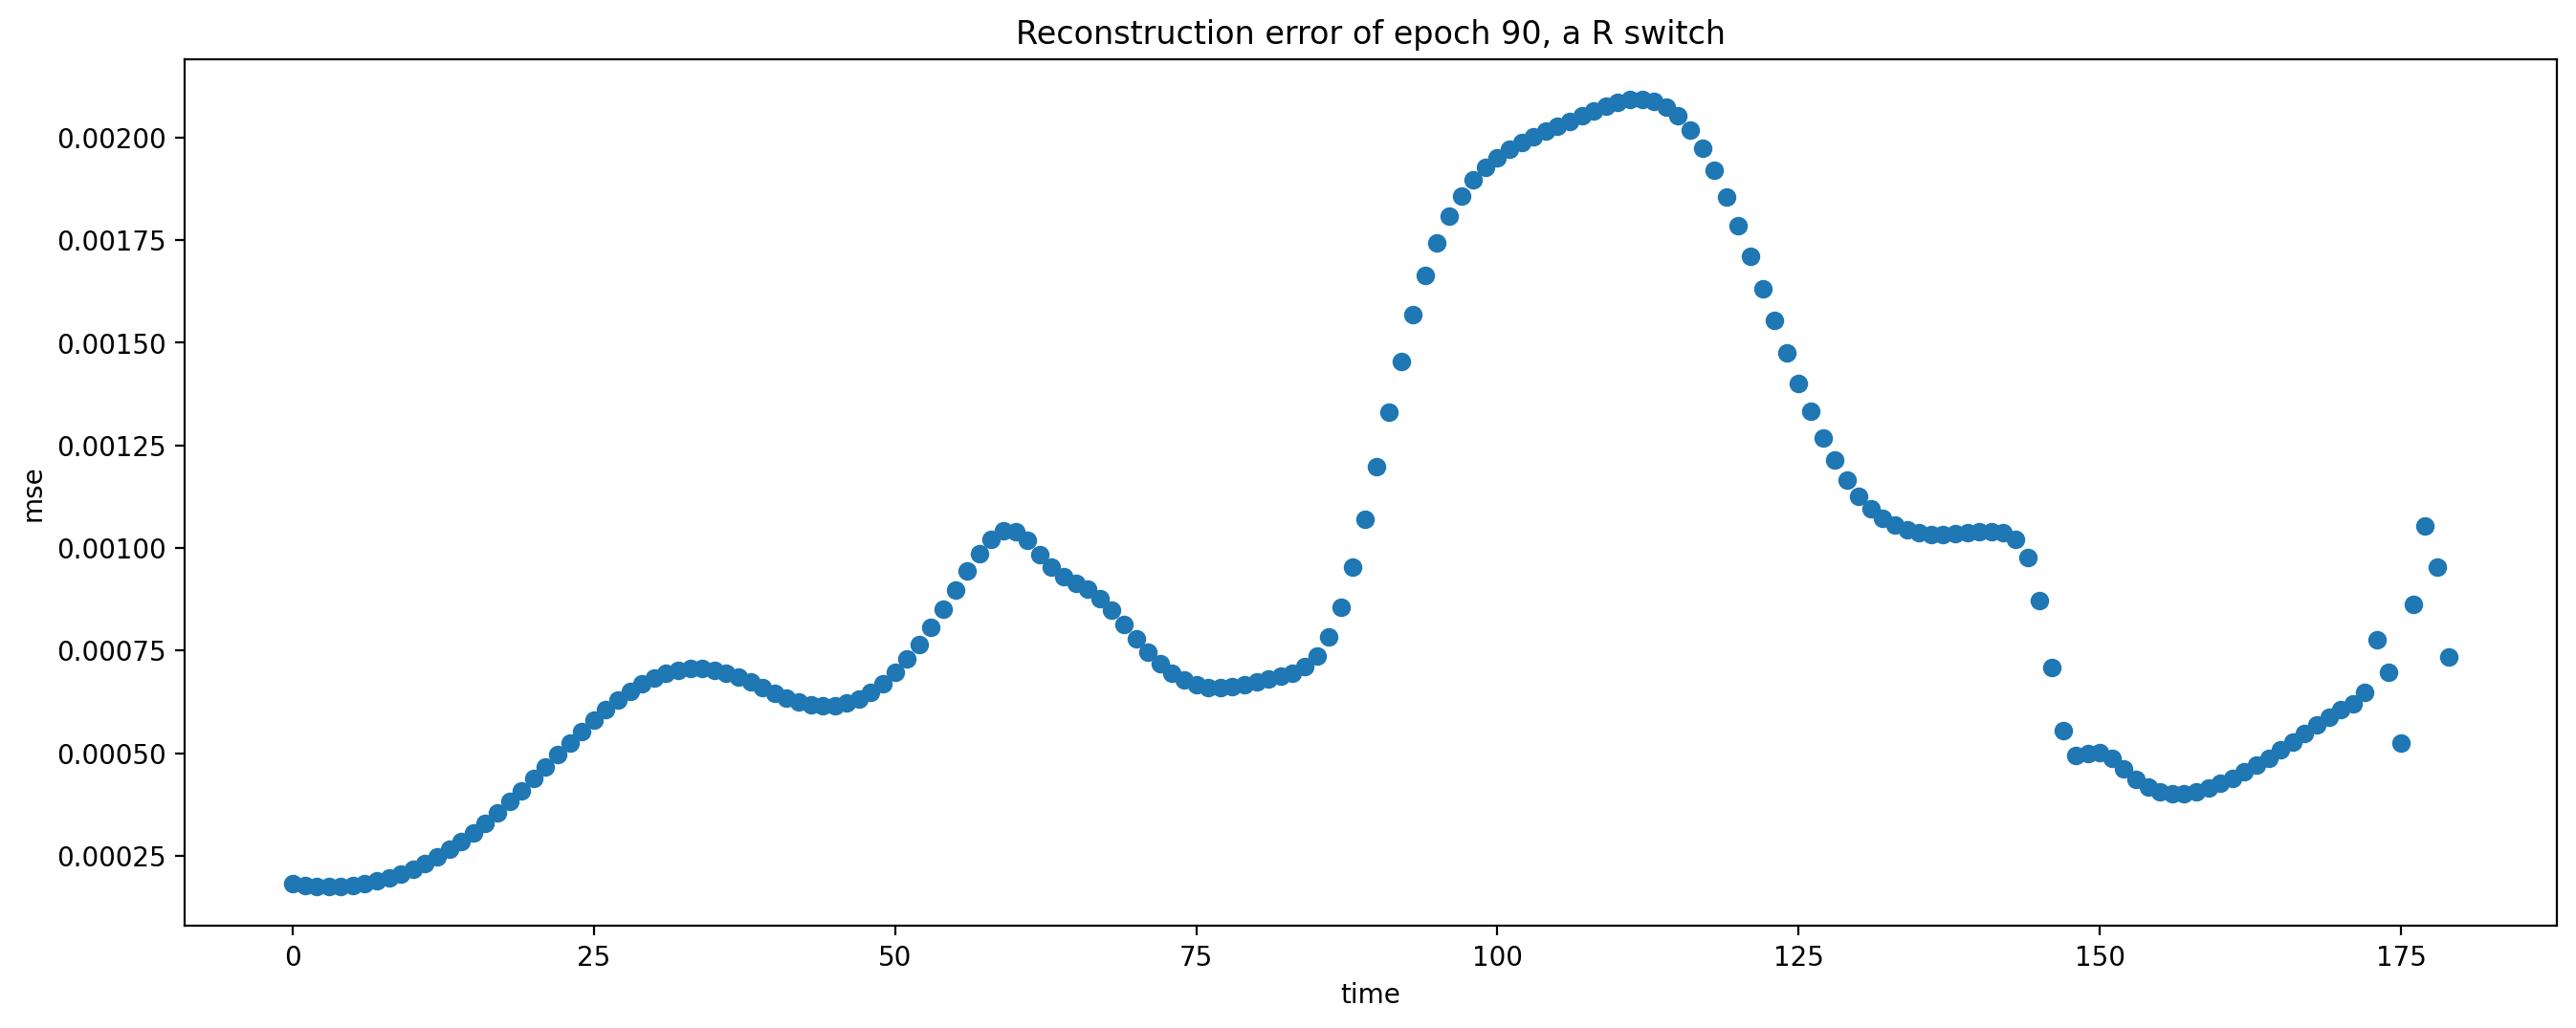

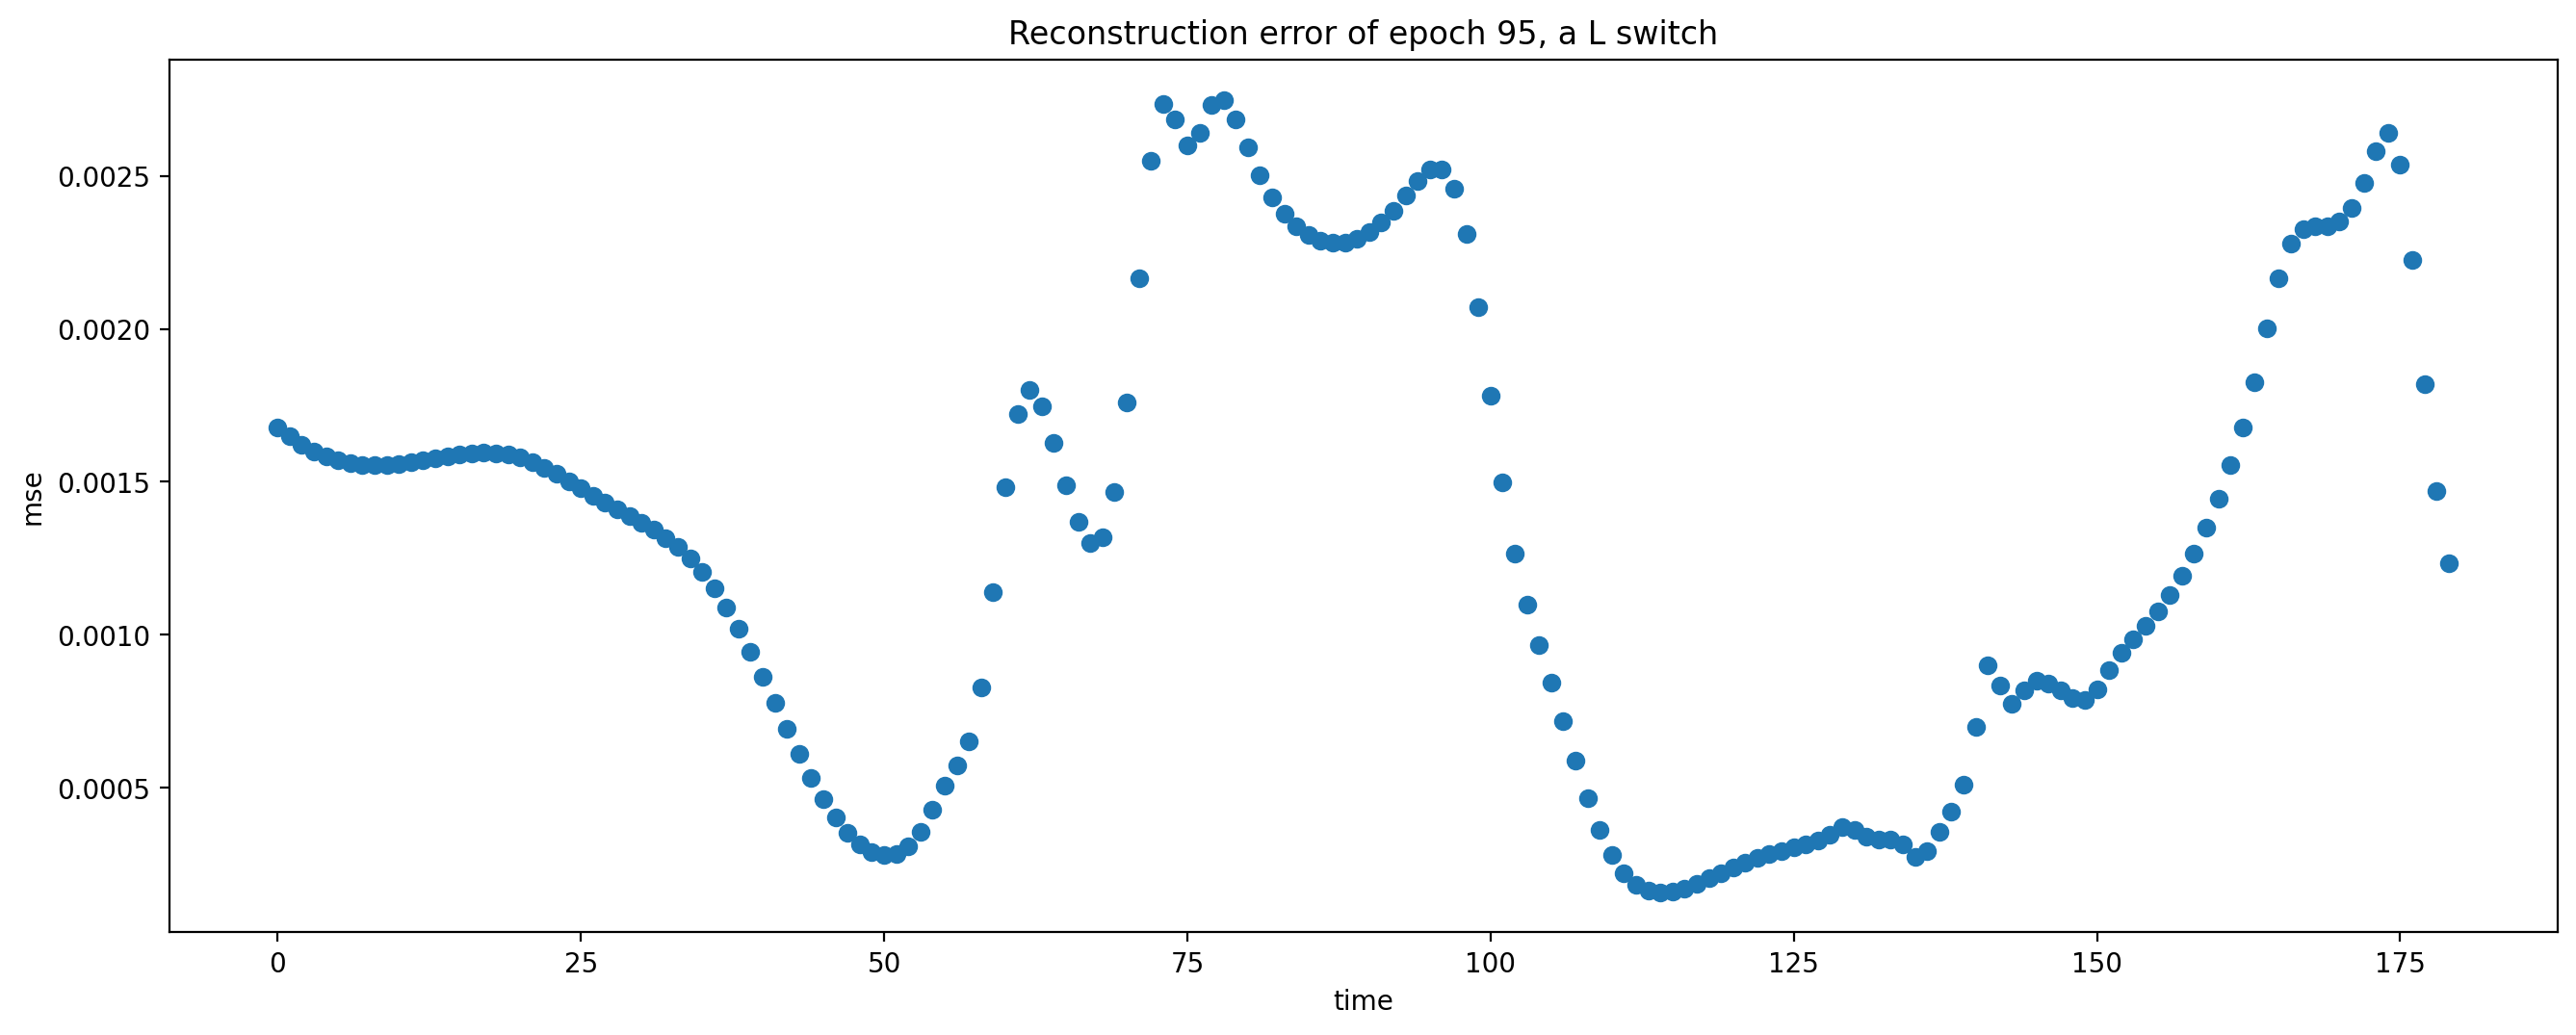

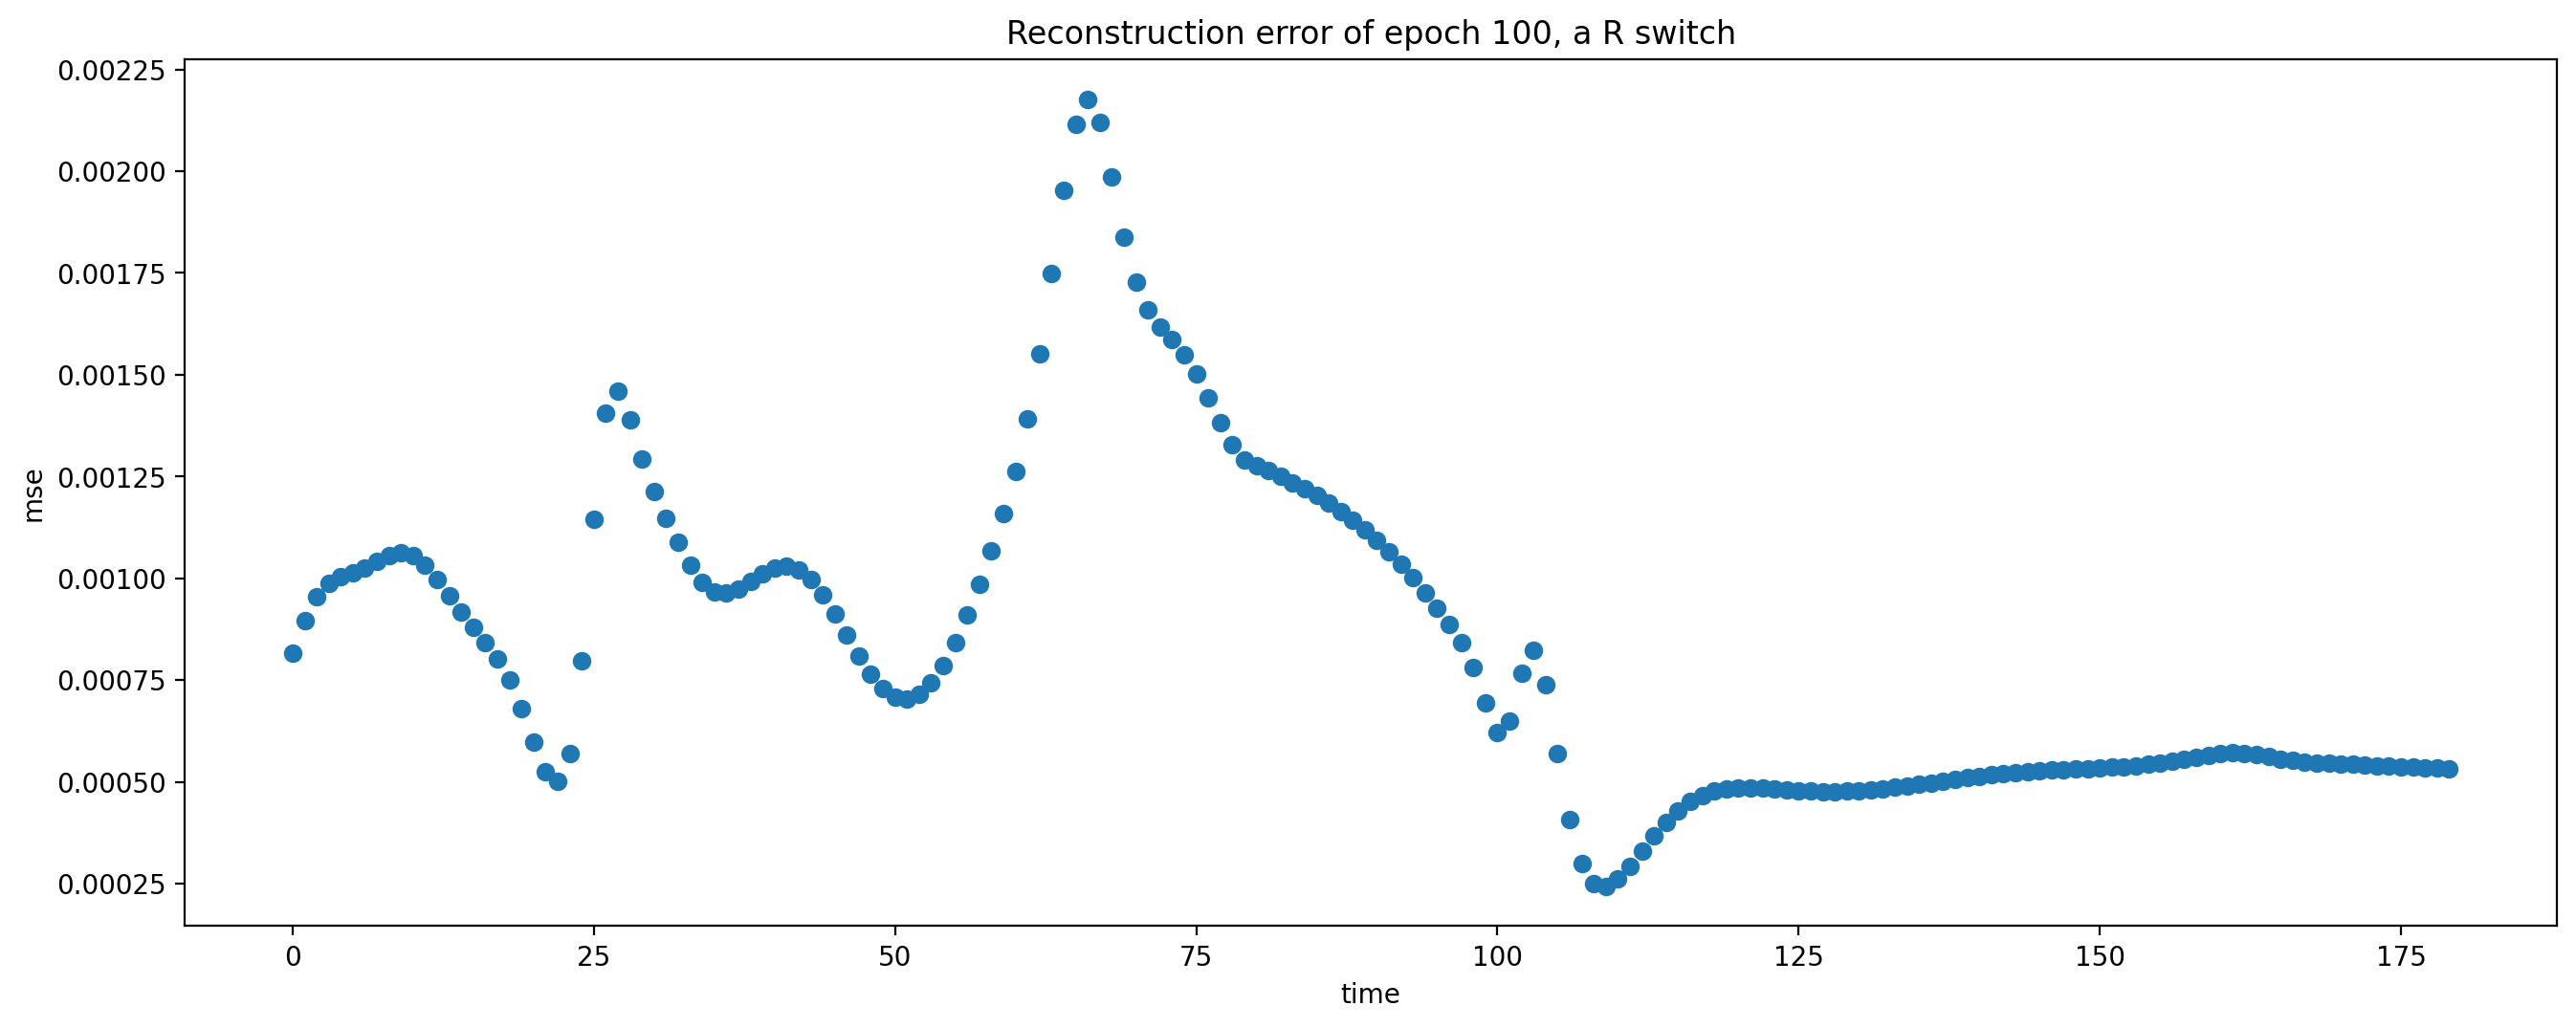

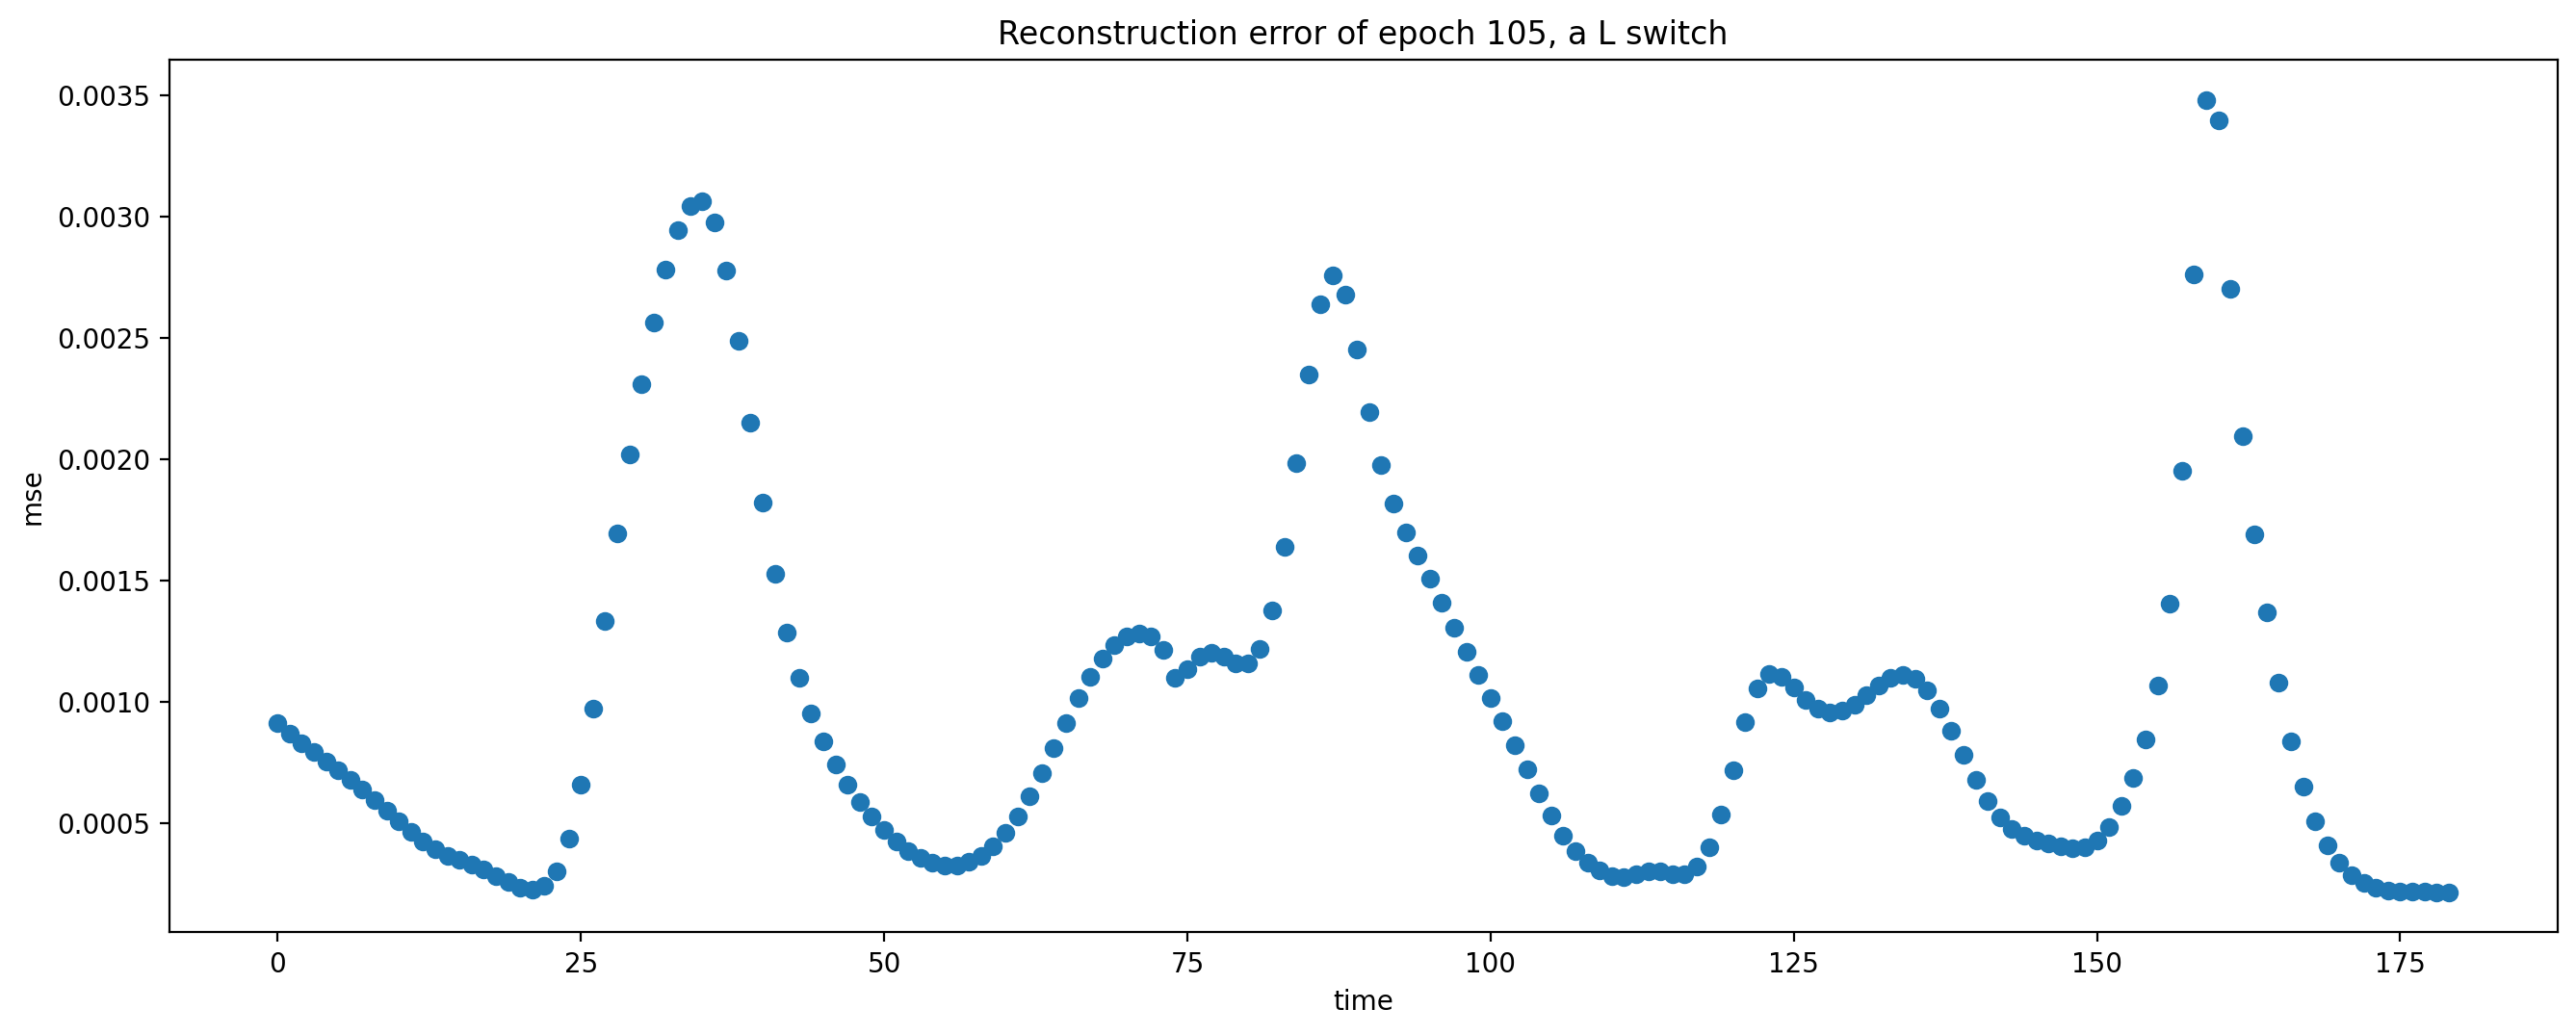

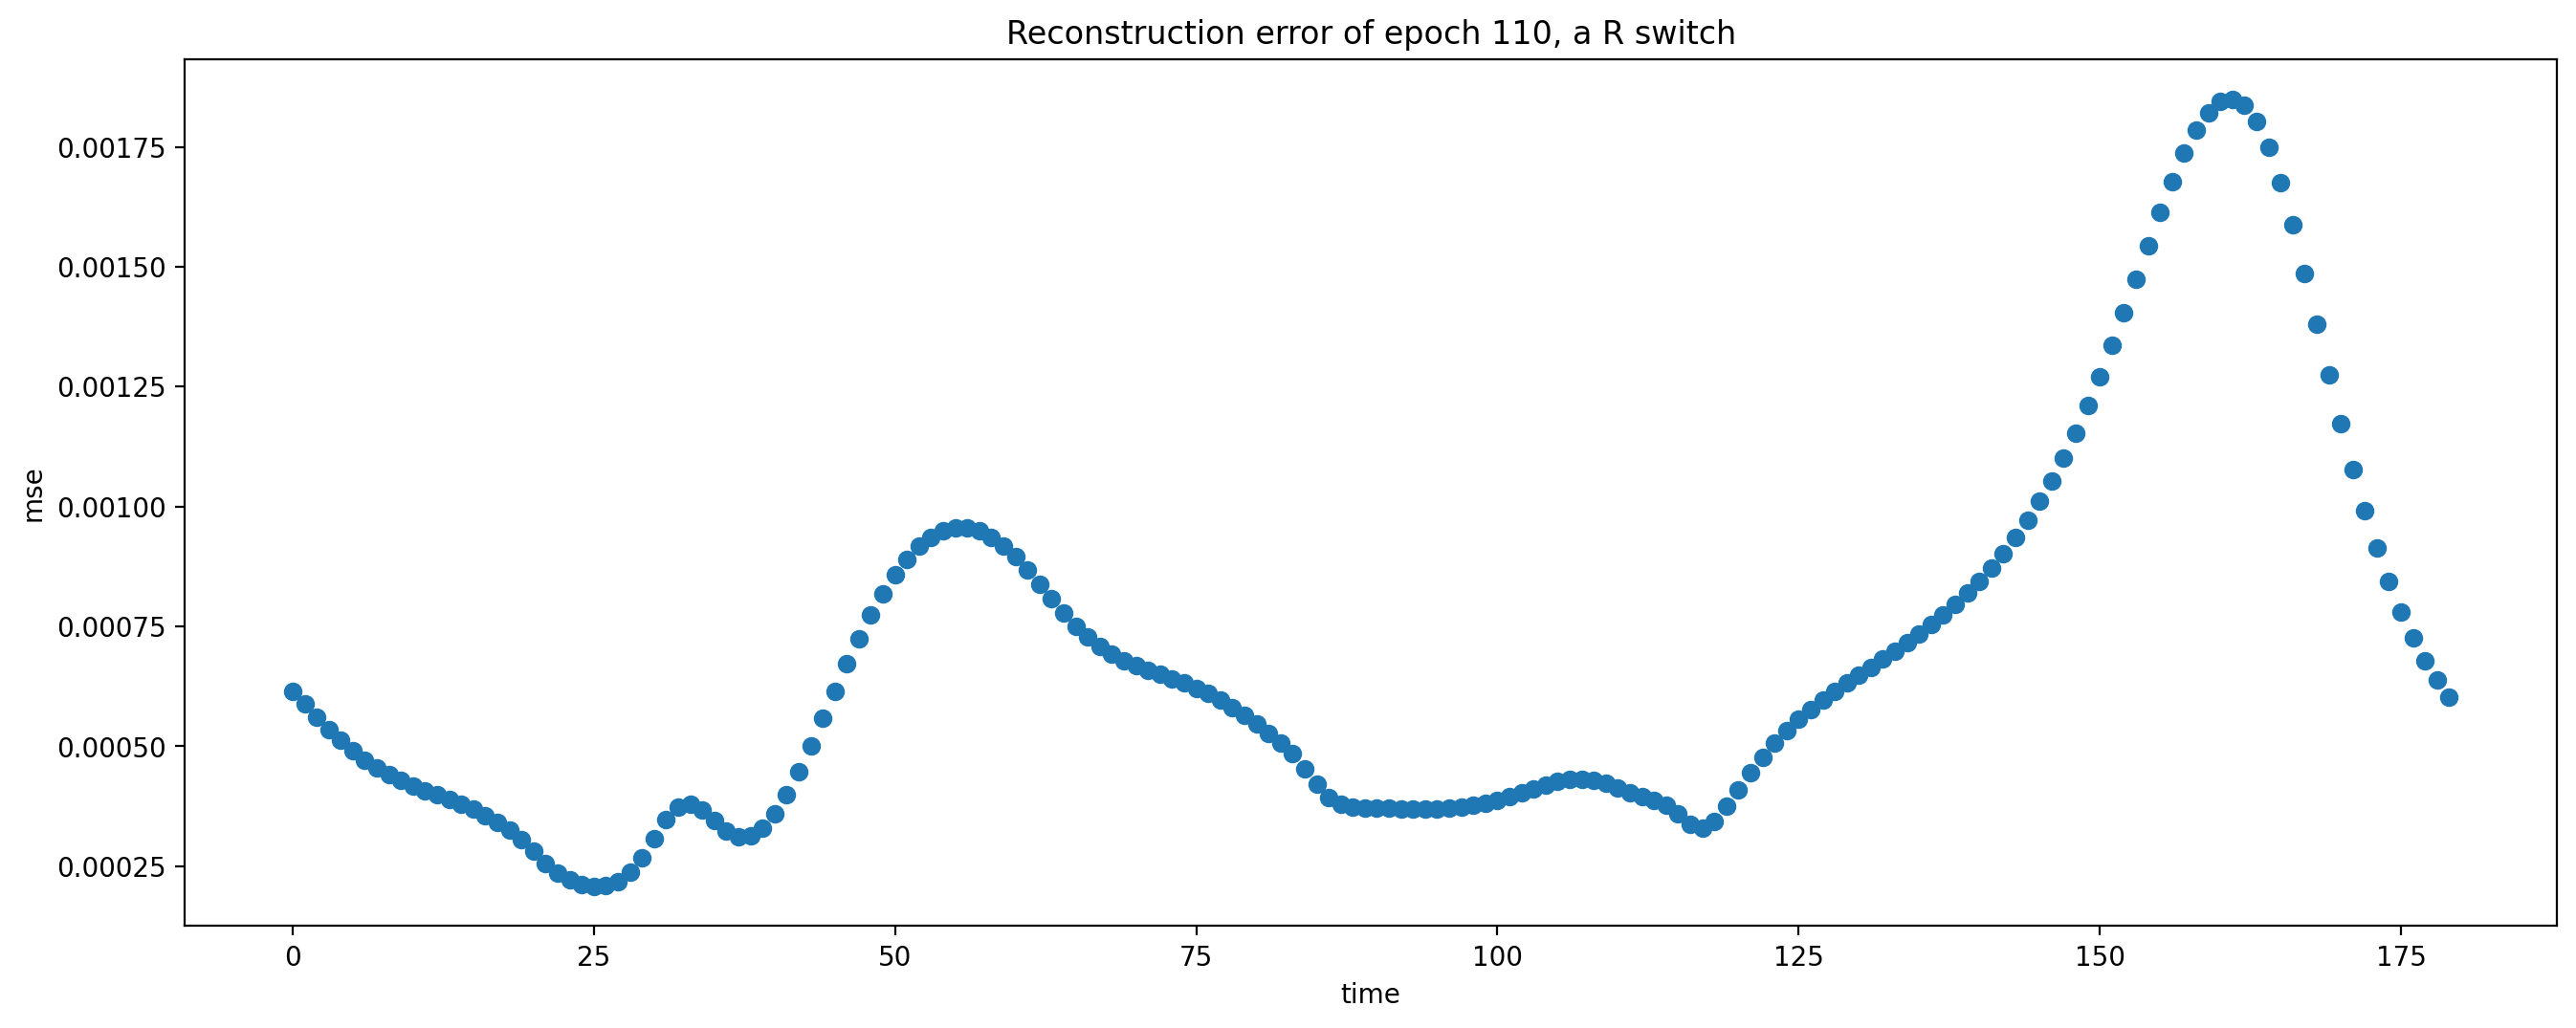

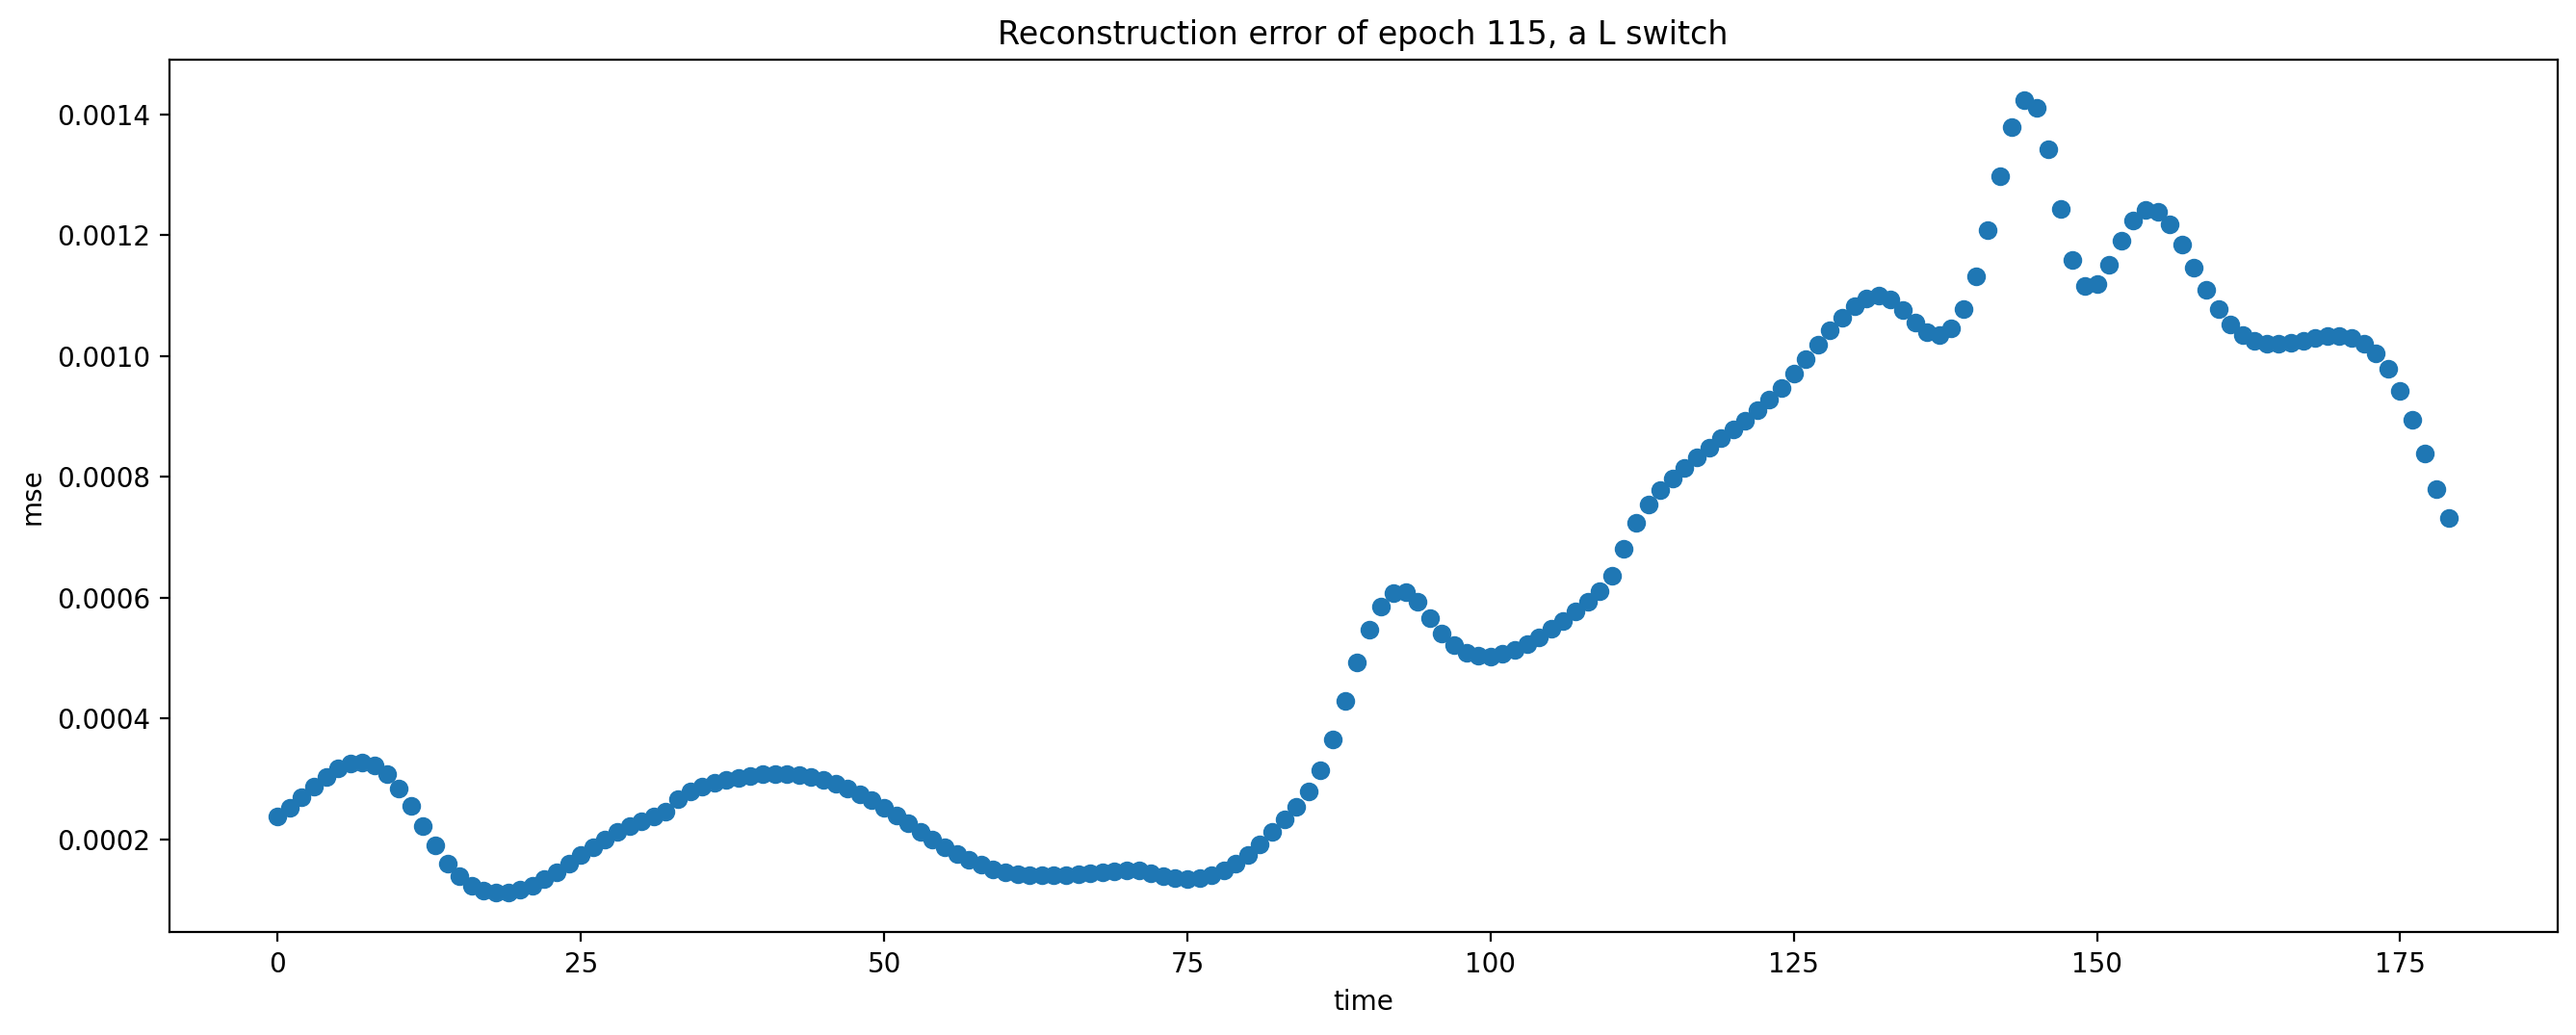

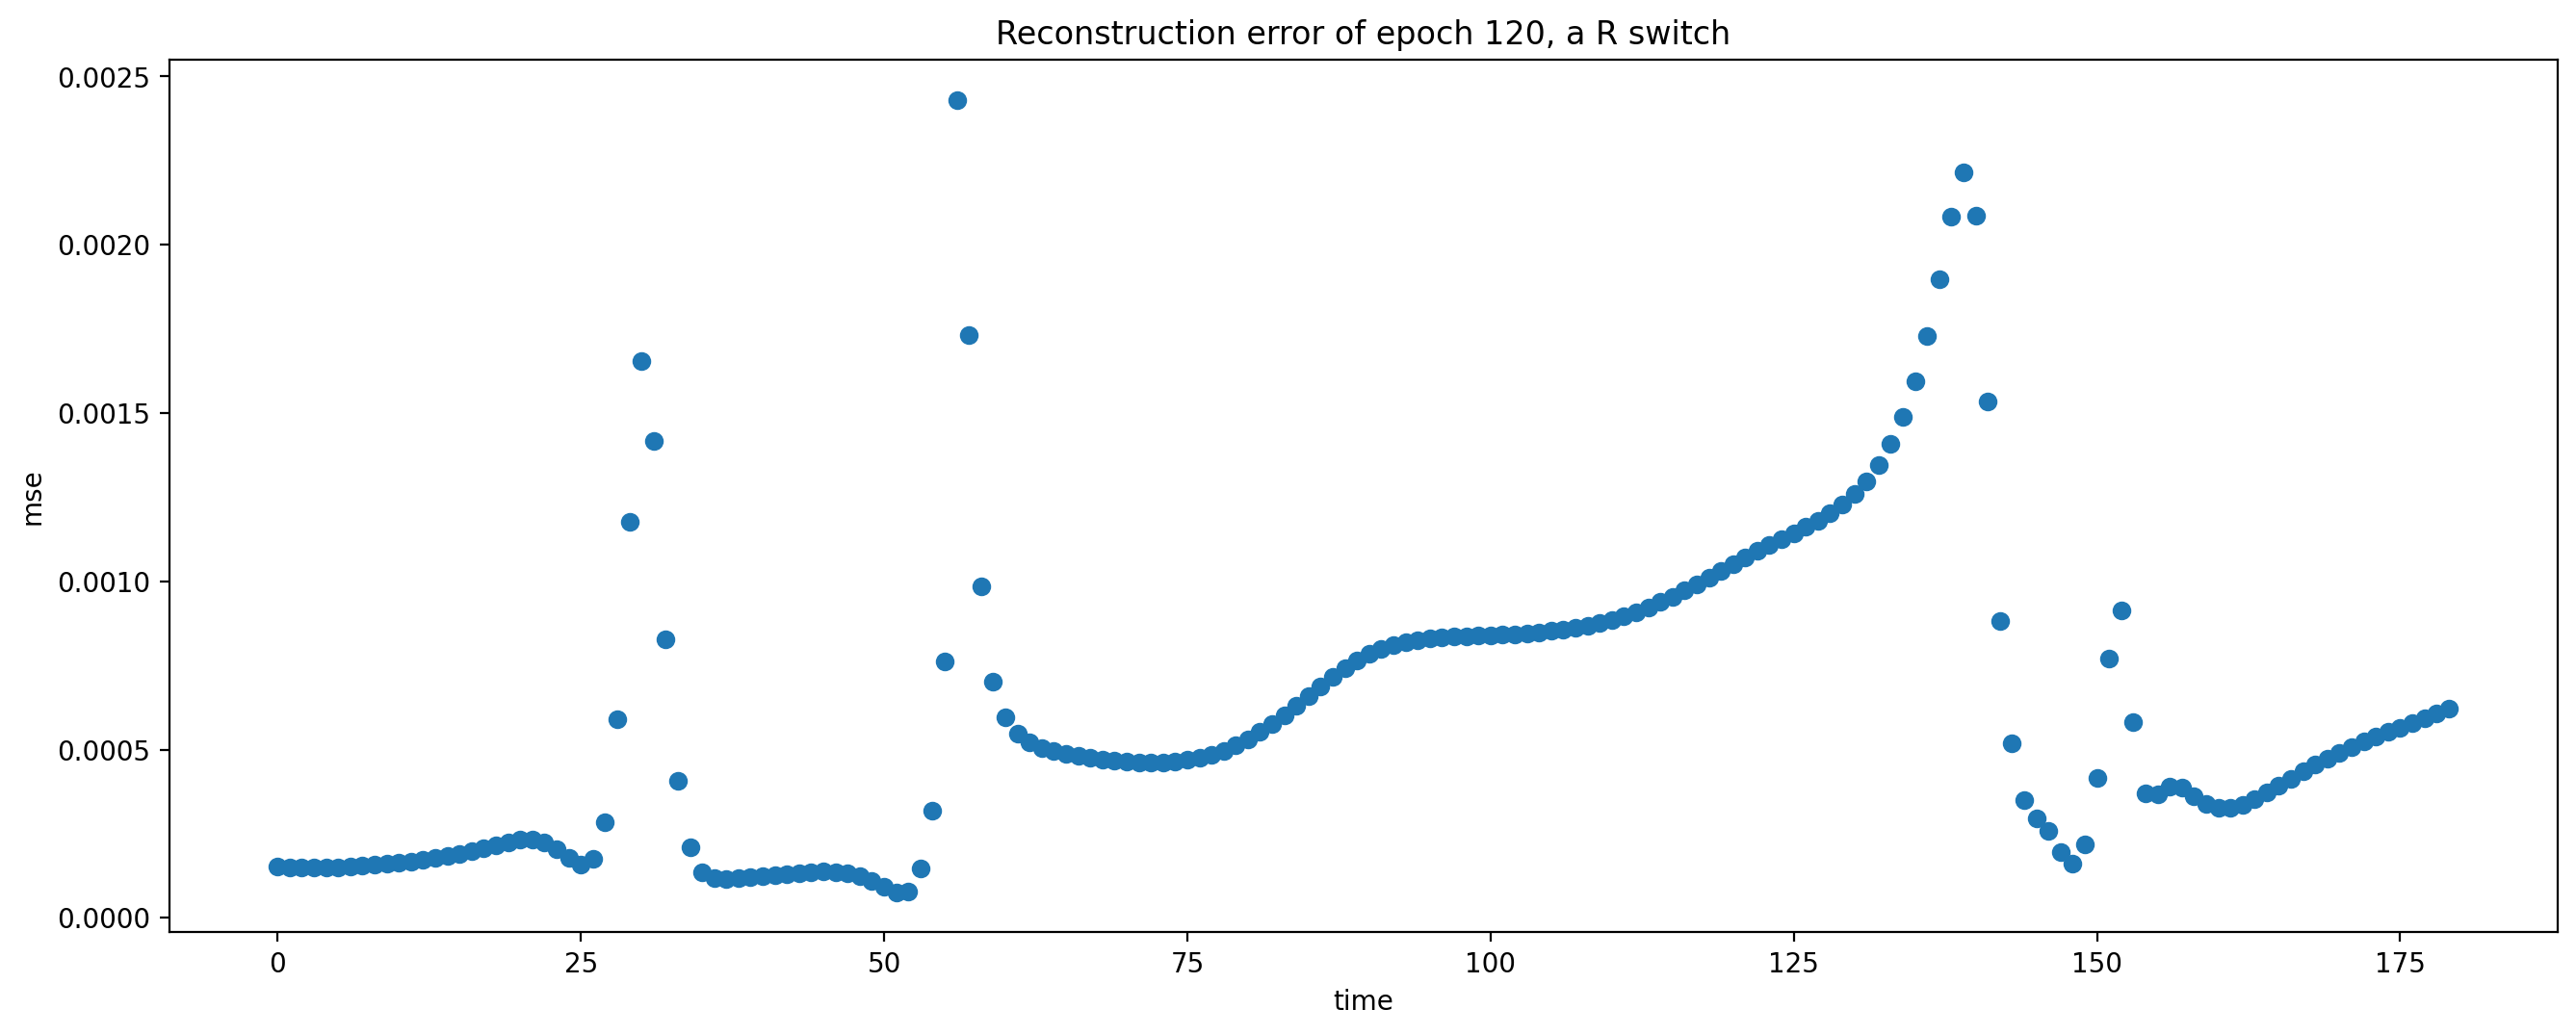

In [44]:
for i in range(low, low+(8*5), 5):
    predictions = model.predict(data[[i]])
    mse = np.mean(np.power(data[[i]] - predictions, 2), axis=2)
    plt.figure(figsize=(16,6), dpi=200)
    plt.scatter(range(data.shape[1]), mse)
    plt.title(f"Reconstruction error of epoch {i}, a " + ("R" if labels[i] else "L") + " switch")
    plt.xlabel('time'); plt.ylabel('mse')
    plt.show()

## Finding Probability Distribution of Samples and Determining Optimal Number of Clusters
- Defining and using the Kolmogorov–Smirnov test to find probability distrubtions. From there, performing hierarchical clustering on the matrix, and then plotting both of the processed matrices.
- Using the probability distribution values to train a hierarchical clustering model. 
- Examinining the dendogram of formed unsupervised model to determine the optimal number of clusters.
- Displaying the probability distribution matrix from the Kolmogorov-Smirnov test, and then displaying the output of the hierarchical clustering on the model. 

In [9]:
def KScoeff(df):
    ks_matrix = np.zeros((len(df),len(df)))
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            ks_test = stats.ks_2samp(df[i], df[j])
            ks_matrix[i,j] = ks_test.statistic
            ks_matrix[j,i] = ks_test.statistic
    return ks_matrix

### COMPUTE KOLMOGOROV SMIRNOV MATRIX ###
df = np.mean(np.power(data[low:] - model.predict(data[low:]), 2), axis=2)
ks_matrix = KScoeff(df)

In [10]:
### HIERACHICAL CLUSTERING ###
d = sch.distance.pdist(ks_matrix)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df_clustered = [df[i] for i in dendrogram['leaves']]
used = [labels[low:][i] for i in dendrogram['leaves']]
ks_clustered = KScoeff(df_clustered)

In [27]:

high = len(ks_matrix)
### this plots the kolmogorov smirnov matrix ###
plt.figure(figsize=(10,10), dpi=500)
plt.imshow(ks_matrix[low:high,low:high])
plt.xticks(range(high-low), labels[low:high])
plt.yticks(range(high-low), labels[low:high])
np.set_printoptions(False)
plt.savefig("kolgo-corr.png", dpi=2500)
plt.show()

### this plots the cluster calculated matrix ###
plt.figure(figsize=(10,10), dpi=500)
plt.imshow(ks_clustered[low:high,low:high])
plt.xticks(range(high-low), used[:high-low])
plt.yticks(range(high-low), used[:high-low])
np.set_printoptions(False)
plt.savefig("clustered.png", dpi=2500)
plt.show()

<Figure size 640x480 with 0 Axes>

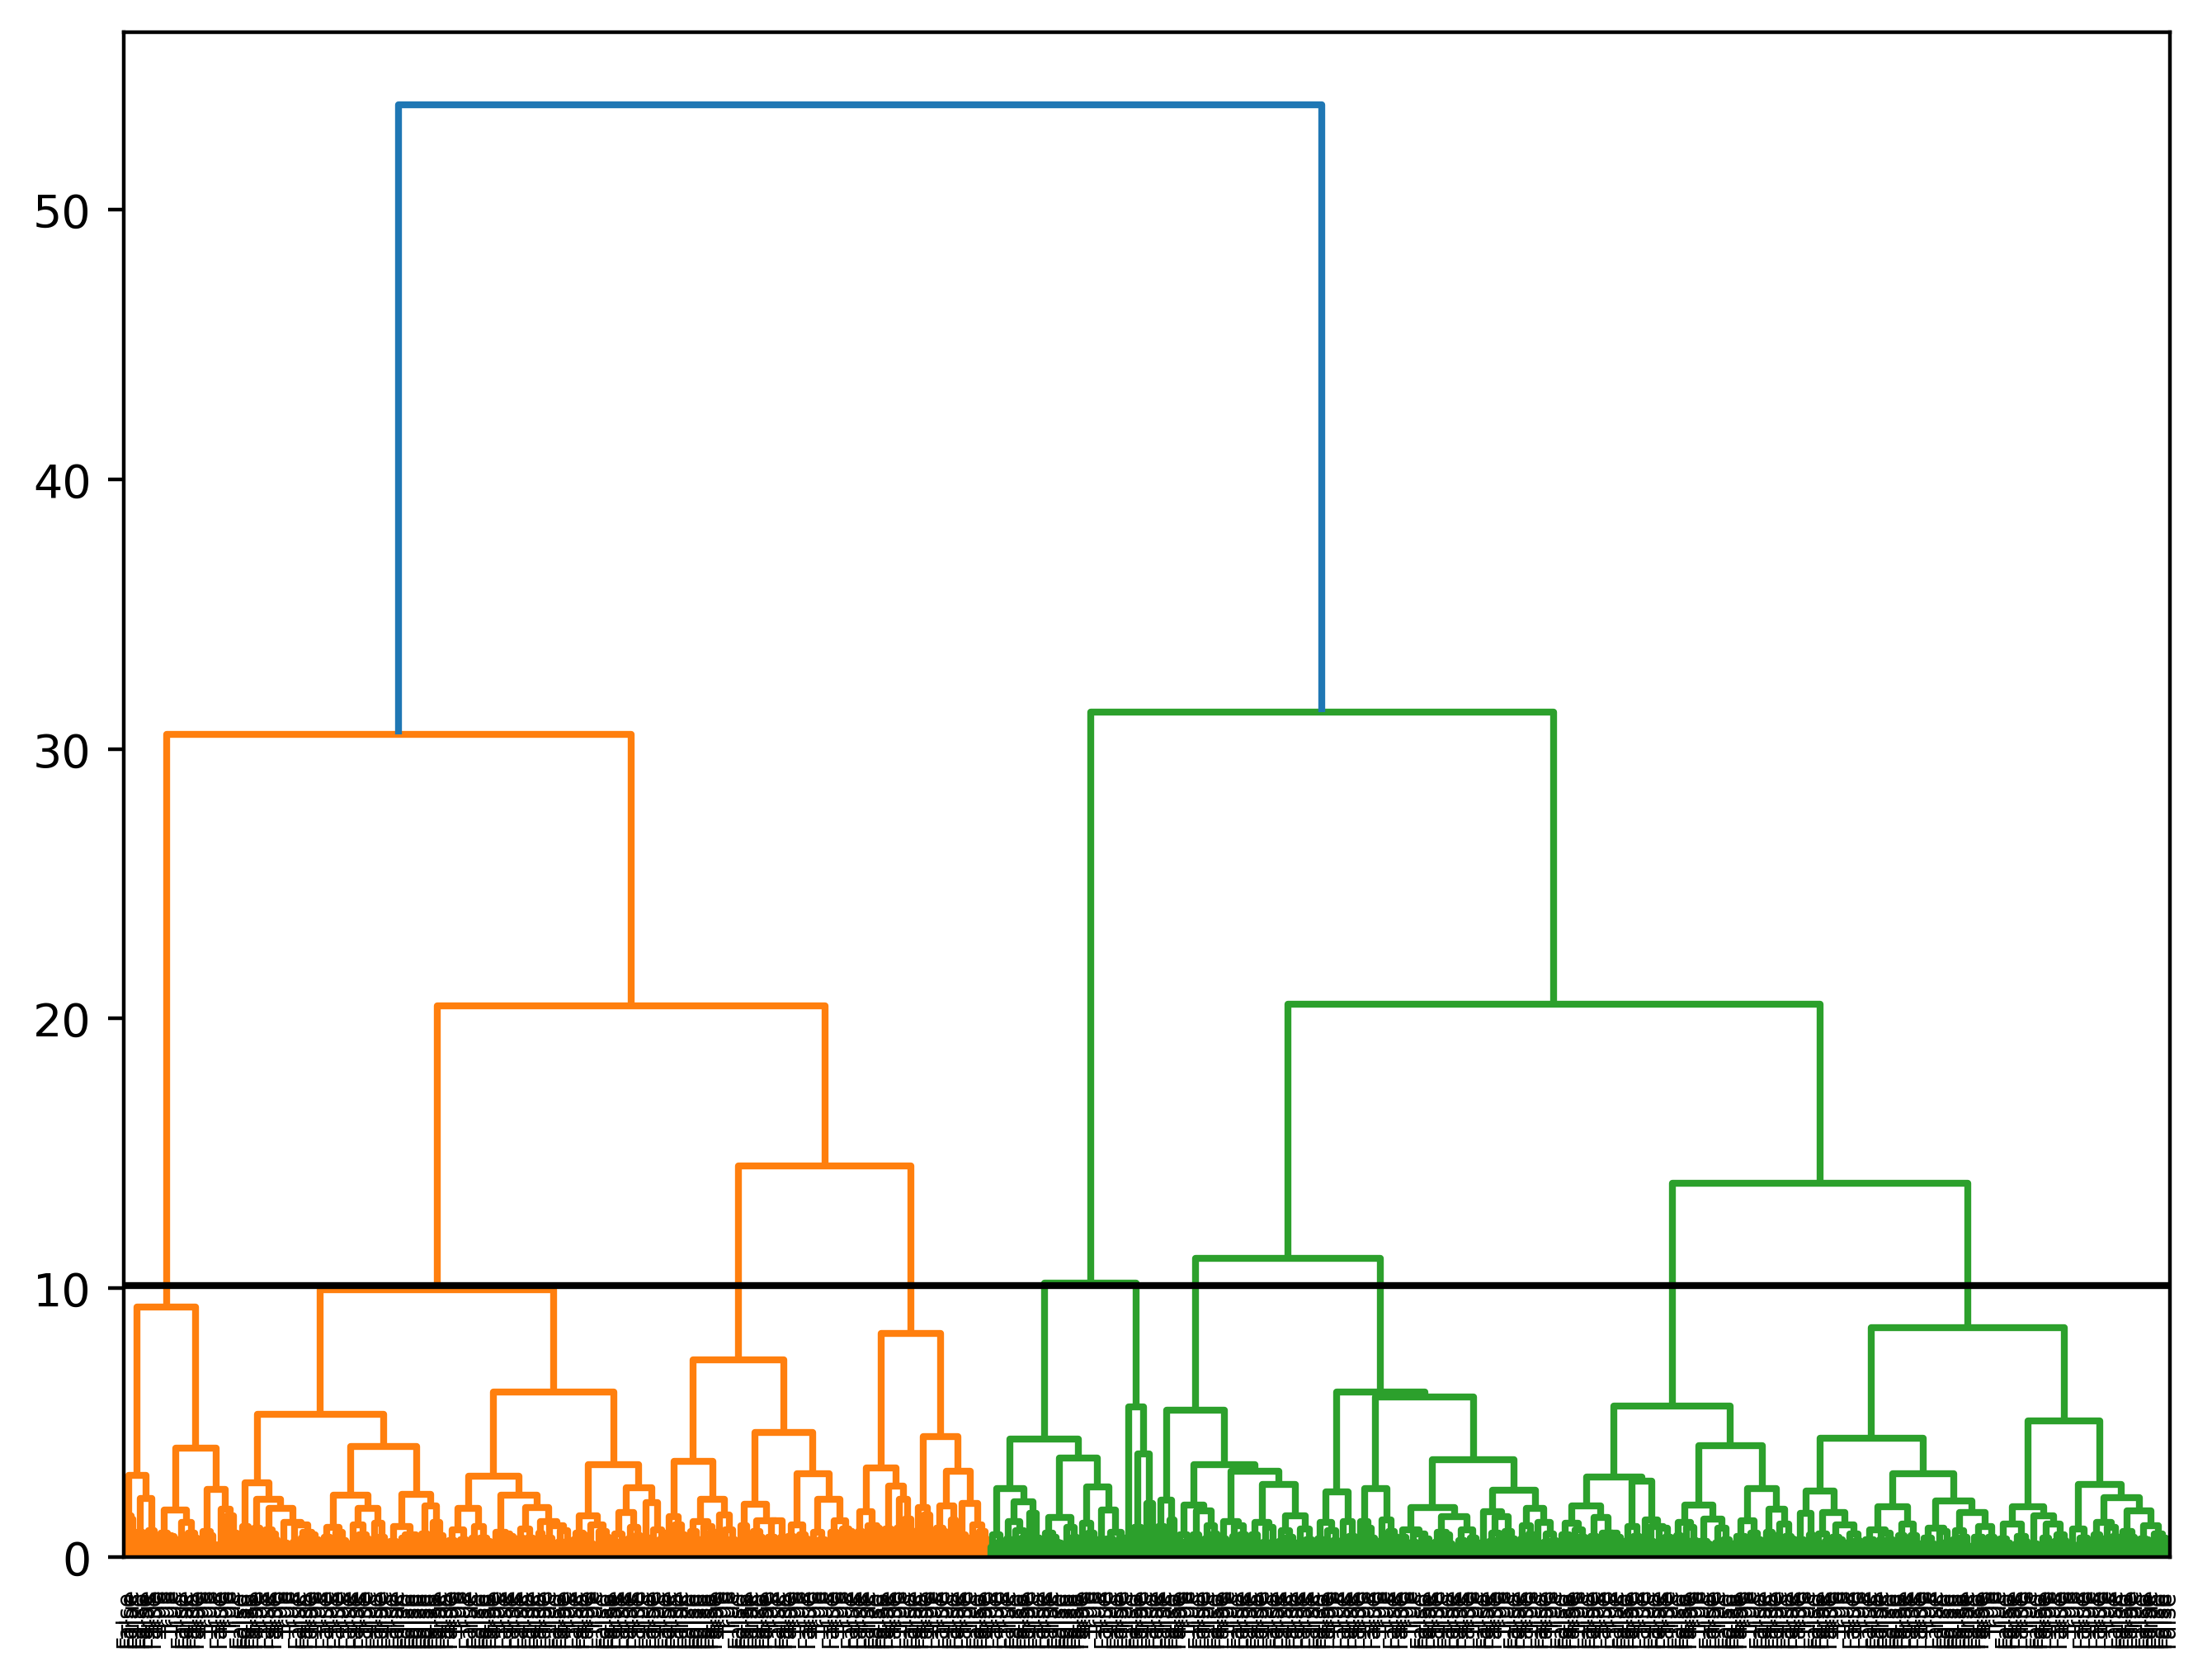

In [34]:
### plotting the dendogram of the clustered values ###
d = sch.distance.pdist(ks_matrix)
L = sch.linkage(d, method='ward')
plt.clf()
plt.figure(figsize=(8,6), dpi=400)
dendrogram = sch.dendrogram(L, labels=used)
plt.axhline(d.max(), c='black')
plt.show()

## Training the Unsupervised Model
- The dendrogram currently shows that 10 clusters is optimal. Thus, an agglomerative cluster model with 10 clusters will be trained. It will be trained with the encoded values of the epochs, which to summarize essentially encodes the data in all the EEG channels used into a single array. The performance of this can be increased by selecting the best models electrodes.
- The label components of the clusters determined are displayed in a plot, which shows significant overlap in labels within a cluster. A better performing model must be trained for clustering to be a viable strategy for determining switches. 

<Figure size 1920x1440 with 0 Axes>

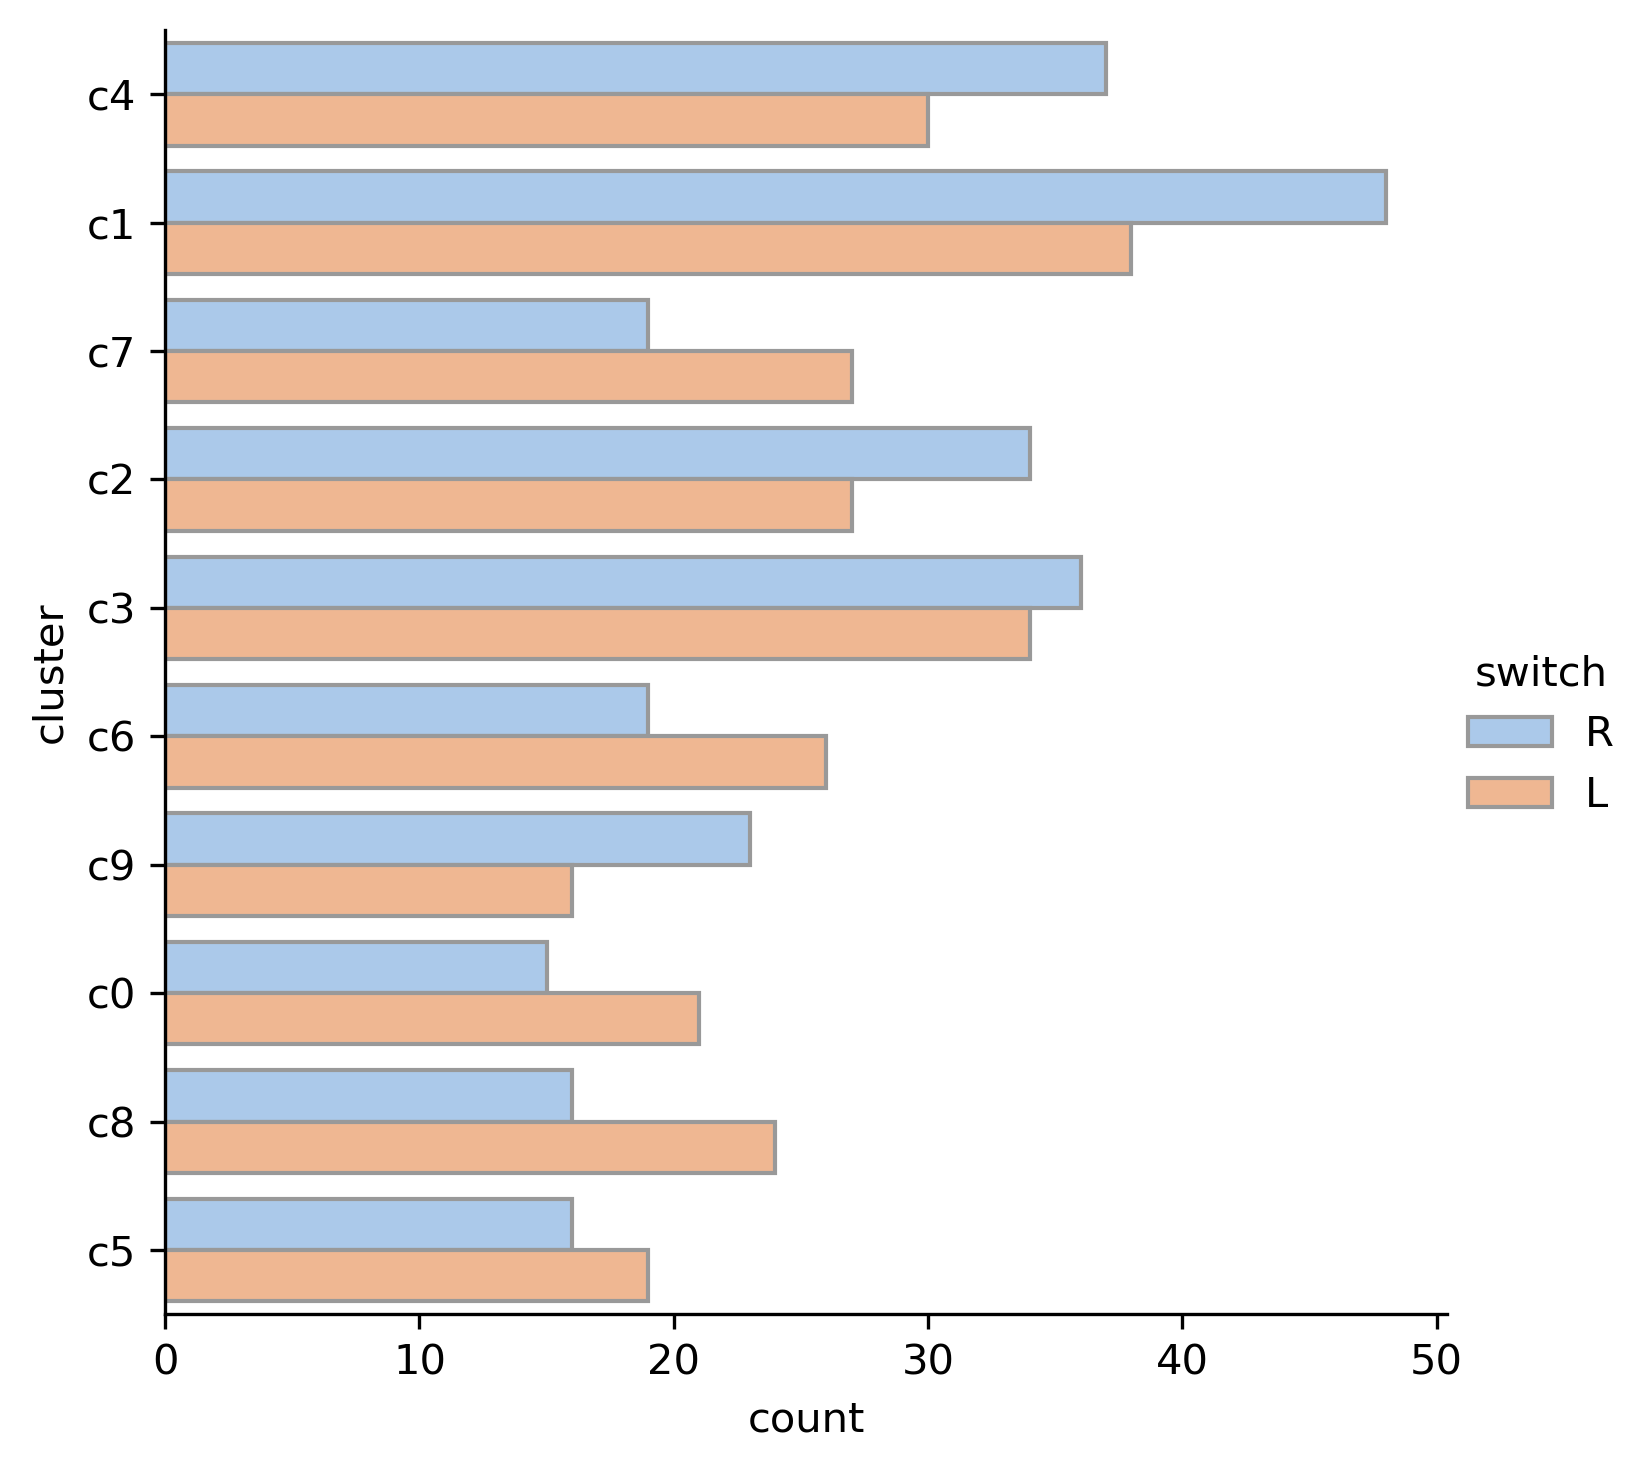

In [82]:
cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
values = cluster.fit_predict(df)

columns = ["cluster", "switch"]
clustered_data = [(f"c{v}", "R" if labels[i] else "L") for i, v in enumerate(values)]
df_clustered = pd.DataFrame(data = clustered_data, columns=columns)
plt.clf()
sns.catplot(y="cluster", hue="switch", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_clustered)
plt.show()
